In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e9/sample_submission.csv
/kaggle/input/playground-series-s5e9/train.csv
/kaggle/input/playground-series-s5e9/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e9/test.csv')

# Data Overview

In [3]:

from IPython.display import display

display(train.head().style.background_gradient(cmap='coolwarm'))


In [4]:
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

Train data shape: (524164, 11)
Test data shape: (174722, 10)


In [5]:
stats_df = train.describe()
display(stats_df.style.background_gradient(cmap='coolwarm').format('{:.4f}'))


# Target Variable Analysis (BeatsPerMinute)

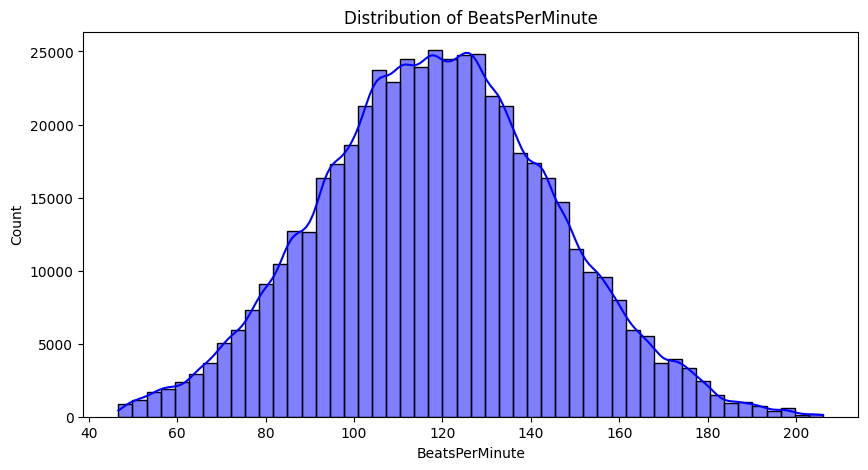

count    524164.000000
mean        119.034899
std          26.468077
min          46.718000
25%         101.070410
50%         118.747660
75%         136.686590
max         206.037000
Name: BeatsPerMinute, dtype: float64
Skewness: 0.0715498677703026
Kurtosis: -0.15446544498930814


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(10,5))
sns.histplot(train["BeatsPerMinute"], bins=50, kde=True, color="blue")
plt.title("Distribution of BeatsPerMinute")
plt.show()

print(train["BeatsPerMinute"].describe())
print("Skewness:", train["BeatsPerMinute"].skew())
print("Kurtosis:", train["BeatsPerMinute"].kurt())


# Numerical Features Analysis

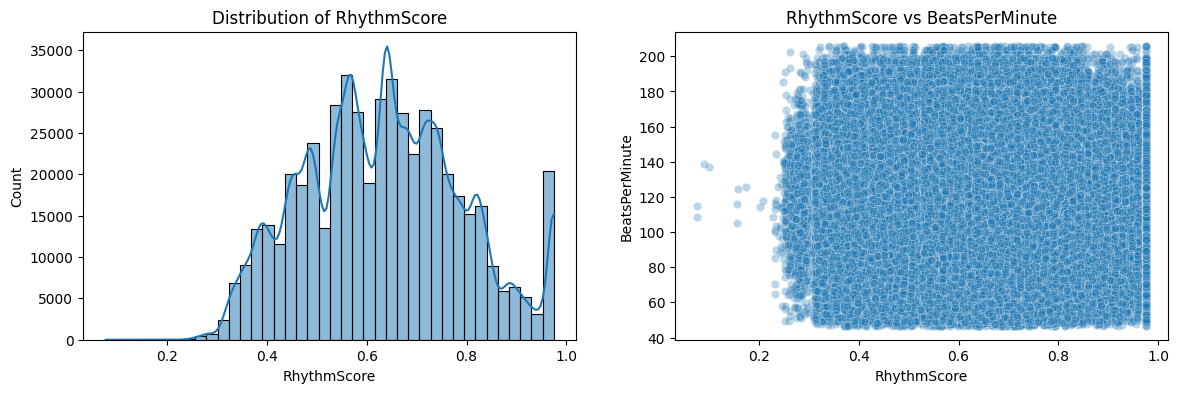

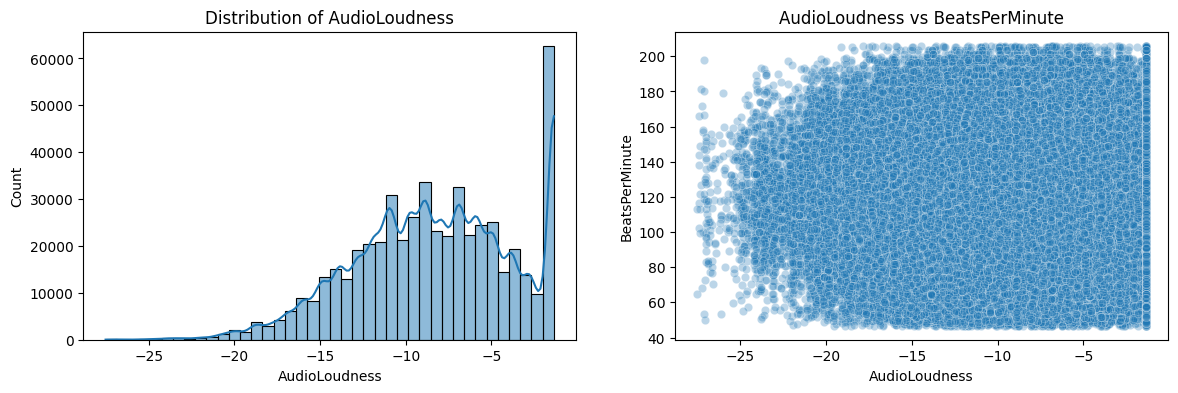

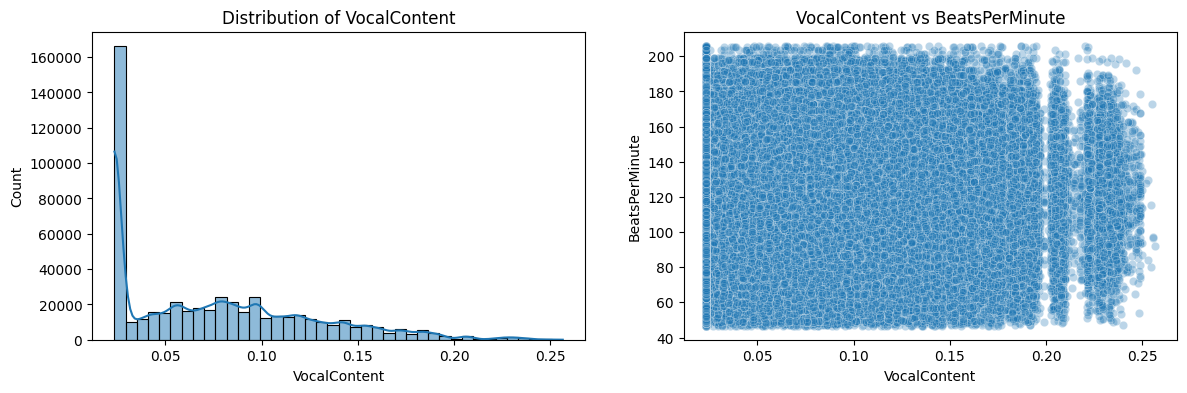

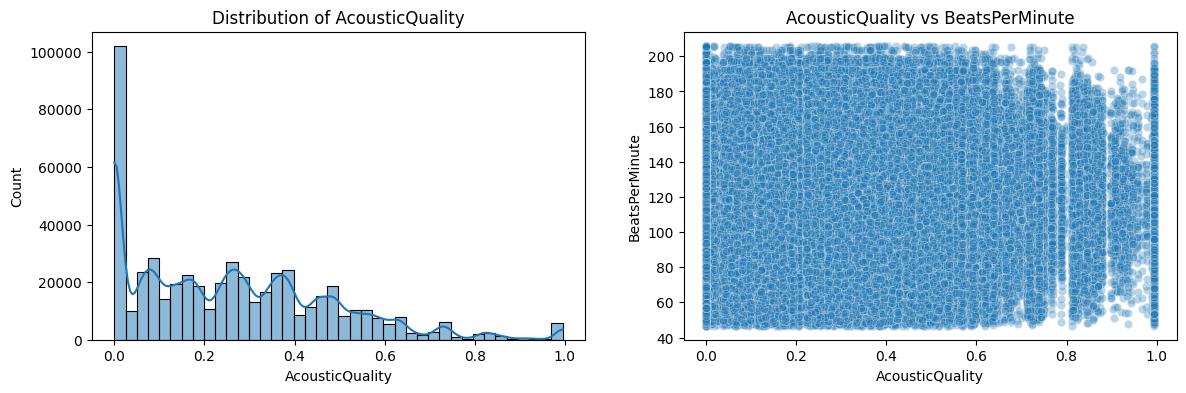

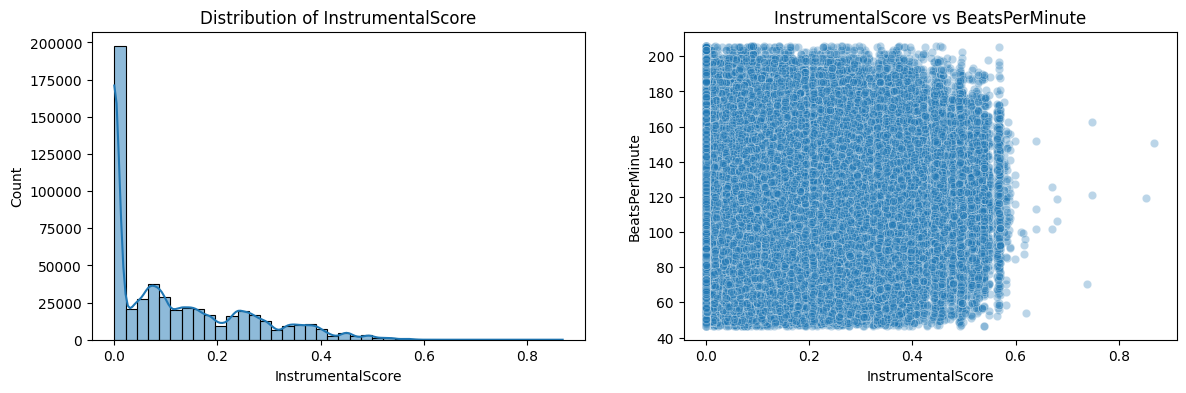

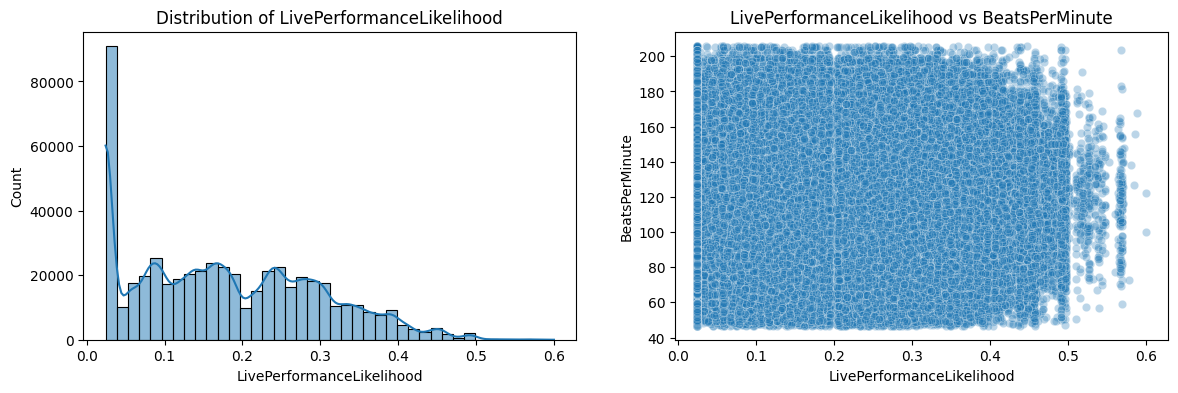

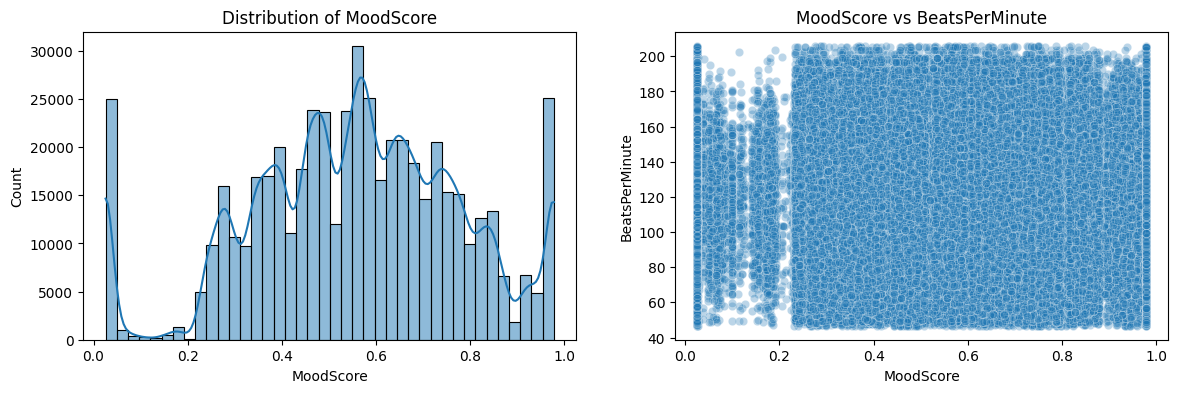

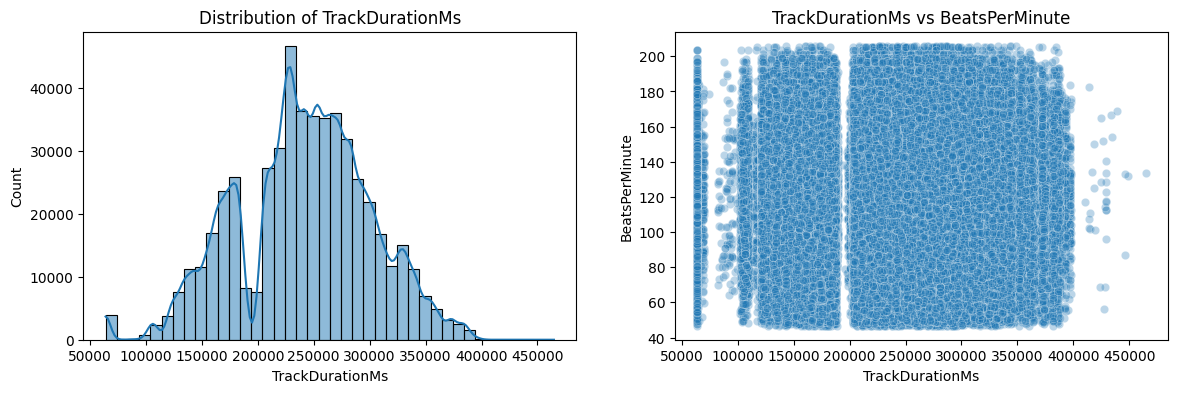

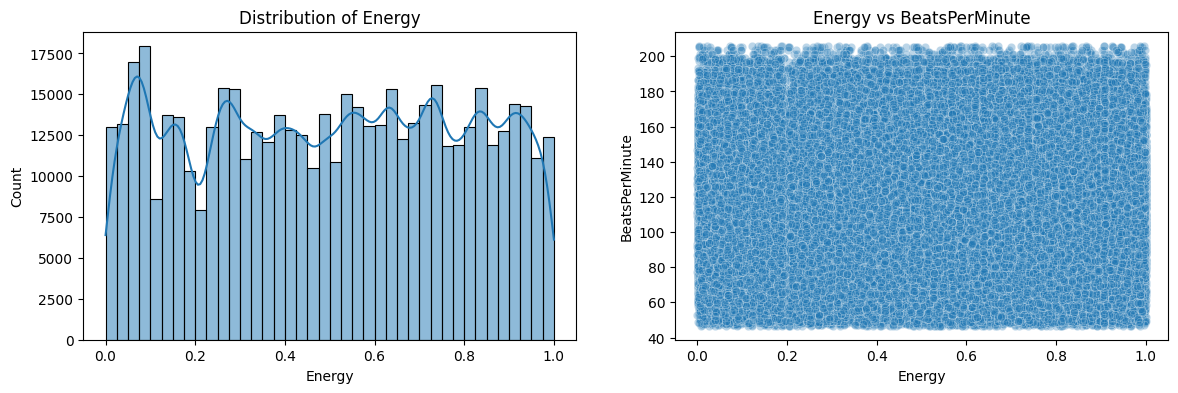

In [7]:
num_features = ["RhythmScore", "AudioLoudness", "VocalContent", "AcousticQuality", 
                "InstrumentalScore", "LivePerformanceLikelihood", "MoodScore", 
                "TrackDurationMs", "Energy"]

for col in num_features:
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)
    sns.histplot(train[col], kde=True, bins=40)
    plt.title(f"Distribution of {col}")
    
    plt.subplot(1,2,2)
    sns.scatterplot(x=train[col], y=train["BeatsPerMinute"], alpha=0.3)
    plt.title(f"{col} vs BeatsPerMinute")
    
    plt.show()


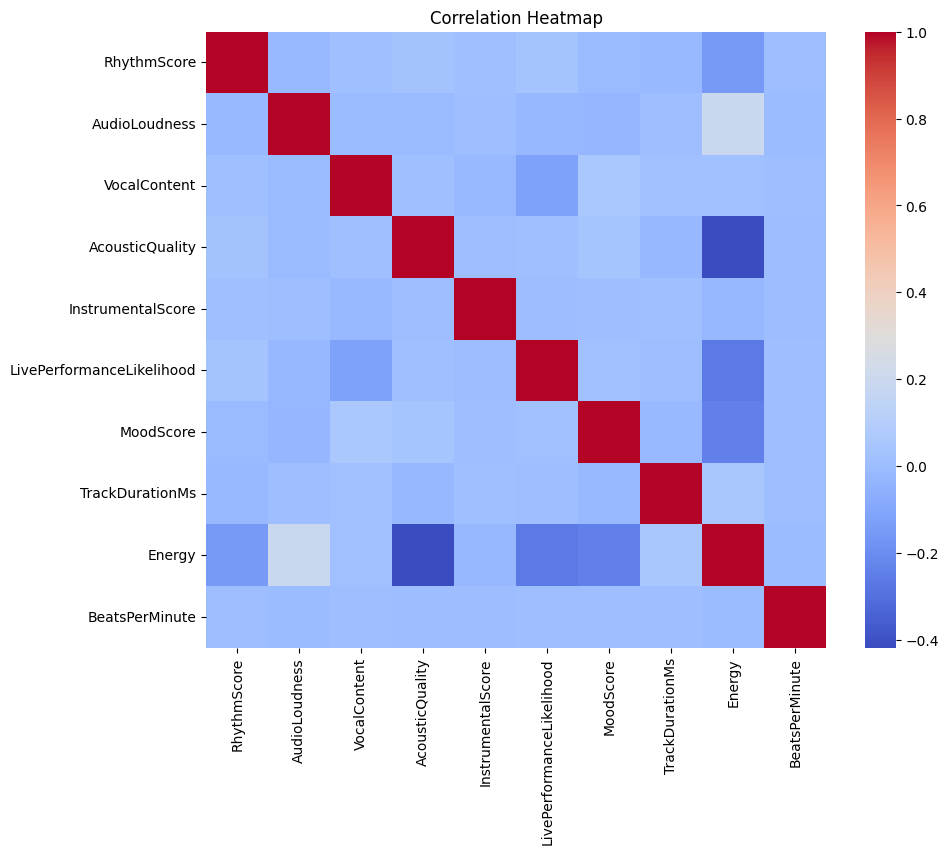

Correlation with BPM:
MoodScore                    0.007059
TrackDurationMs              0.006637
RhythmScore                  0.005440
VocalContent                 0.004876
LivePerformanceLikelihood    0.003471
InstrumentalScore            0.001900
AcousticQuality             -0.000820
AudioLoudness               -0.003327
Energy                      -0.004375
Name: BeatsPerMinute, dtype: float64


In [8]:

corr = train.drop("id", axis=1).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

corr_target = corr["BeatsPerMinute"].drop("BeatsPerMinute").sort_values(ascending=False)
print("Correlation with BPM:")
print(corr_target)


# Feature Relationships

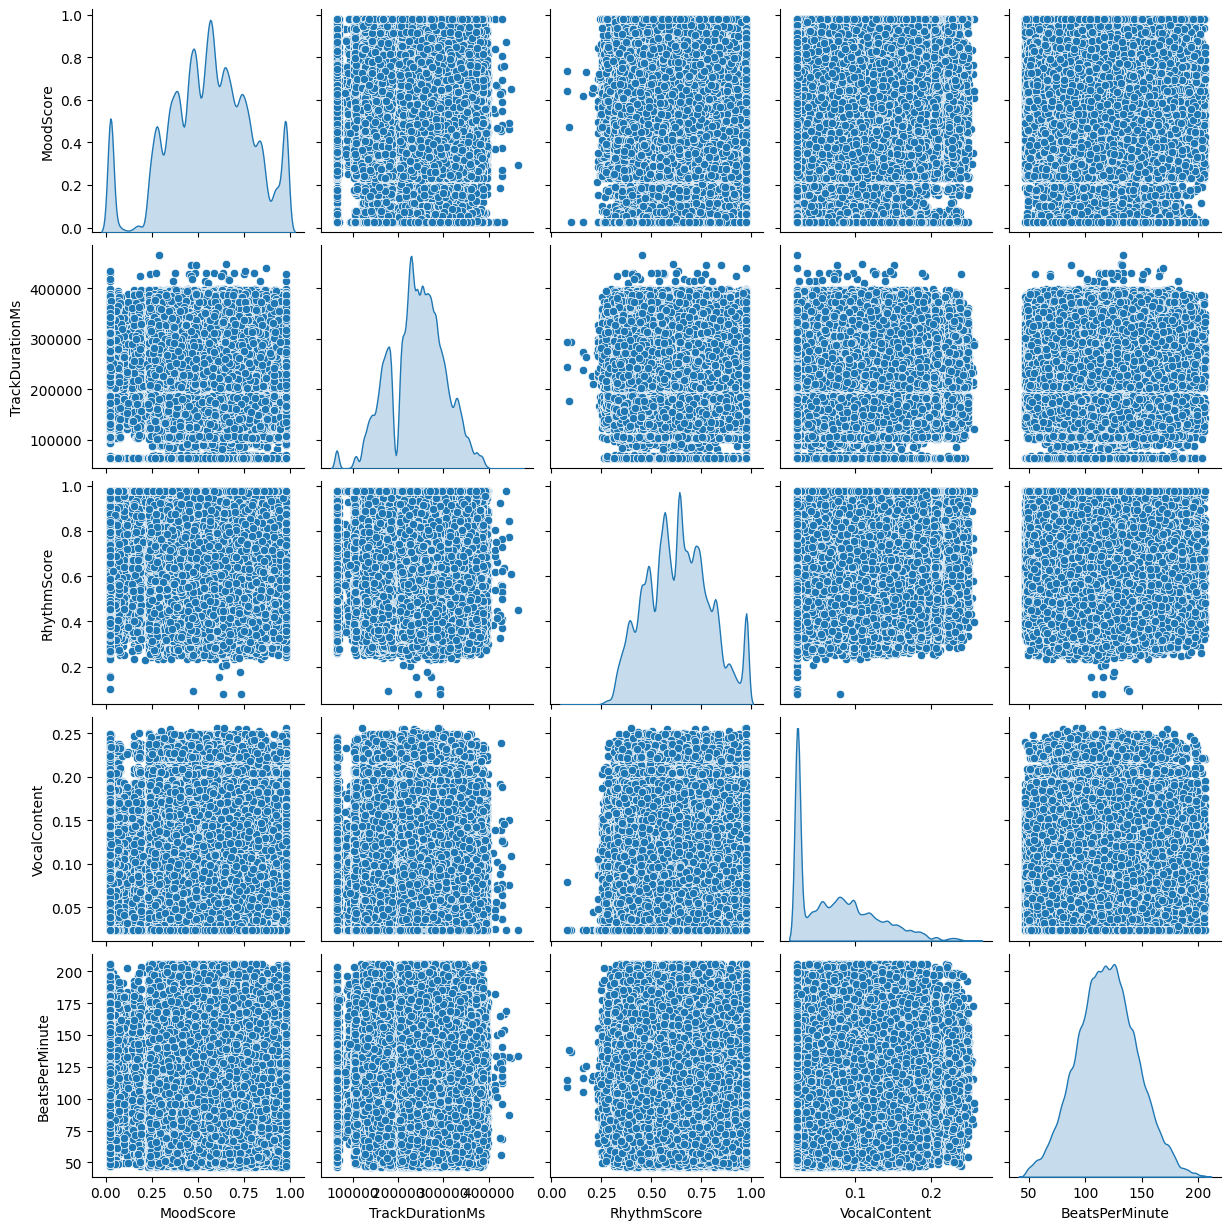

In [9]:

top_features = corr_target.abs().sort_values(ascending=False).head(4).index.tolist()

sns.pairplot(train[top_features + ["BeatsPerMinute"]], diag_kind="kde")
plt.show()



# Outlier Check

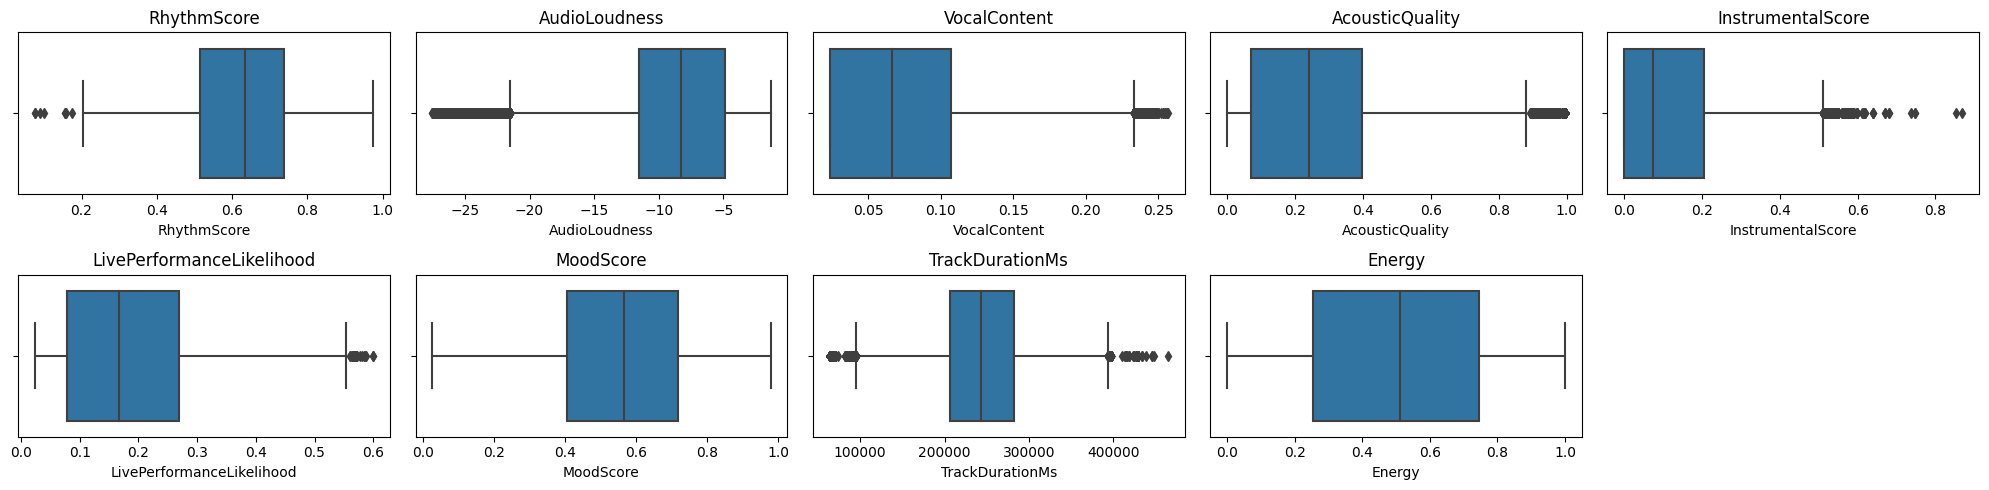

In [10]:
num_features = [col for col in train.columns if col not in ["id", "BeatsPerMinute"]]

fig, axes = plt.subplots(len(num_features)//5 + 1, 5, figsize=(20, 3*len(num_features)//5))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(col)

# remove empty plots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Train vs Test KDE distributions

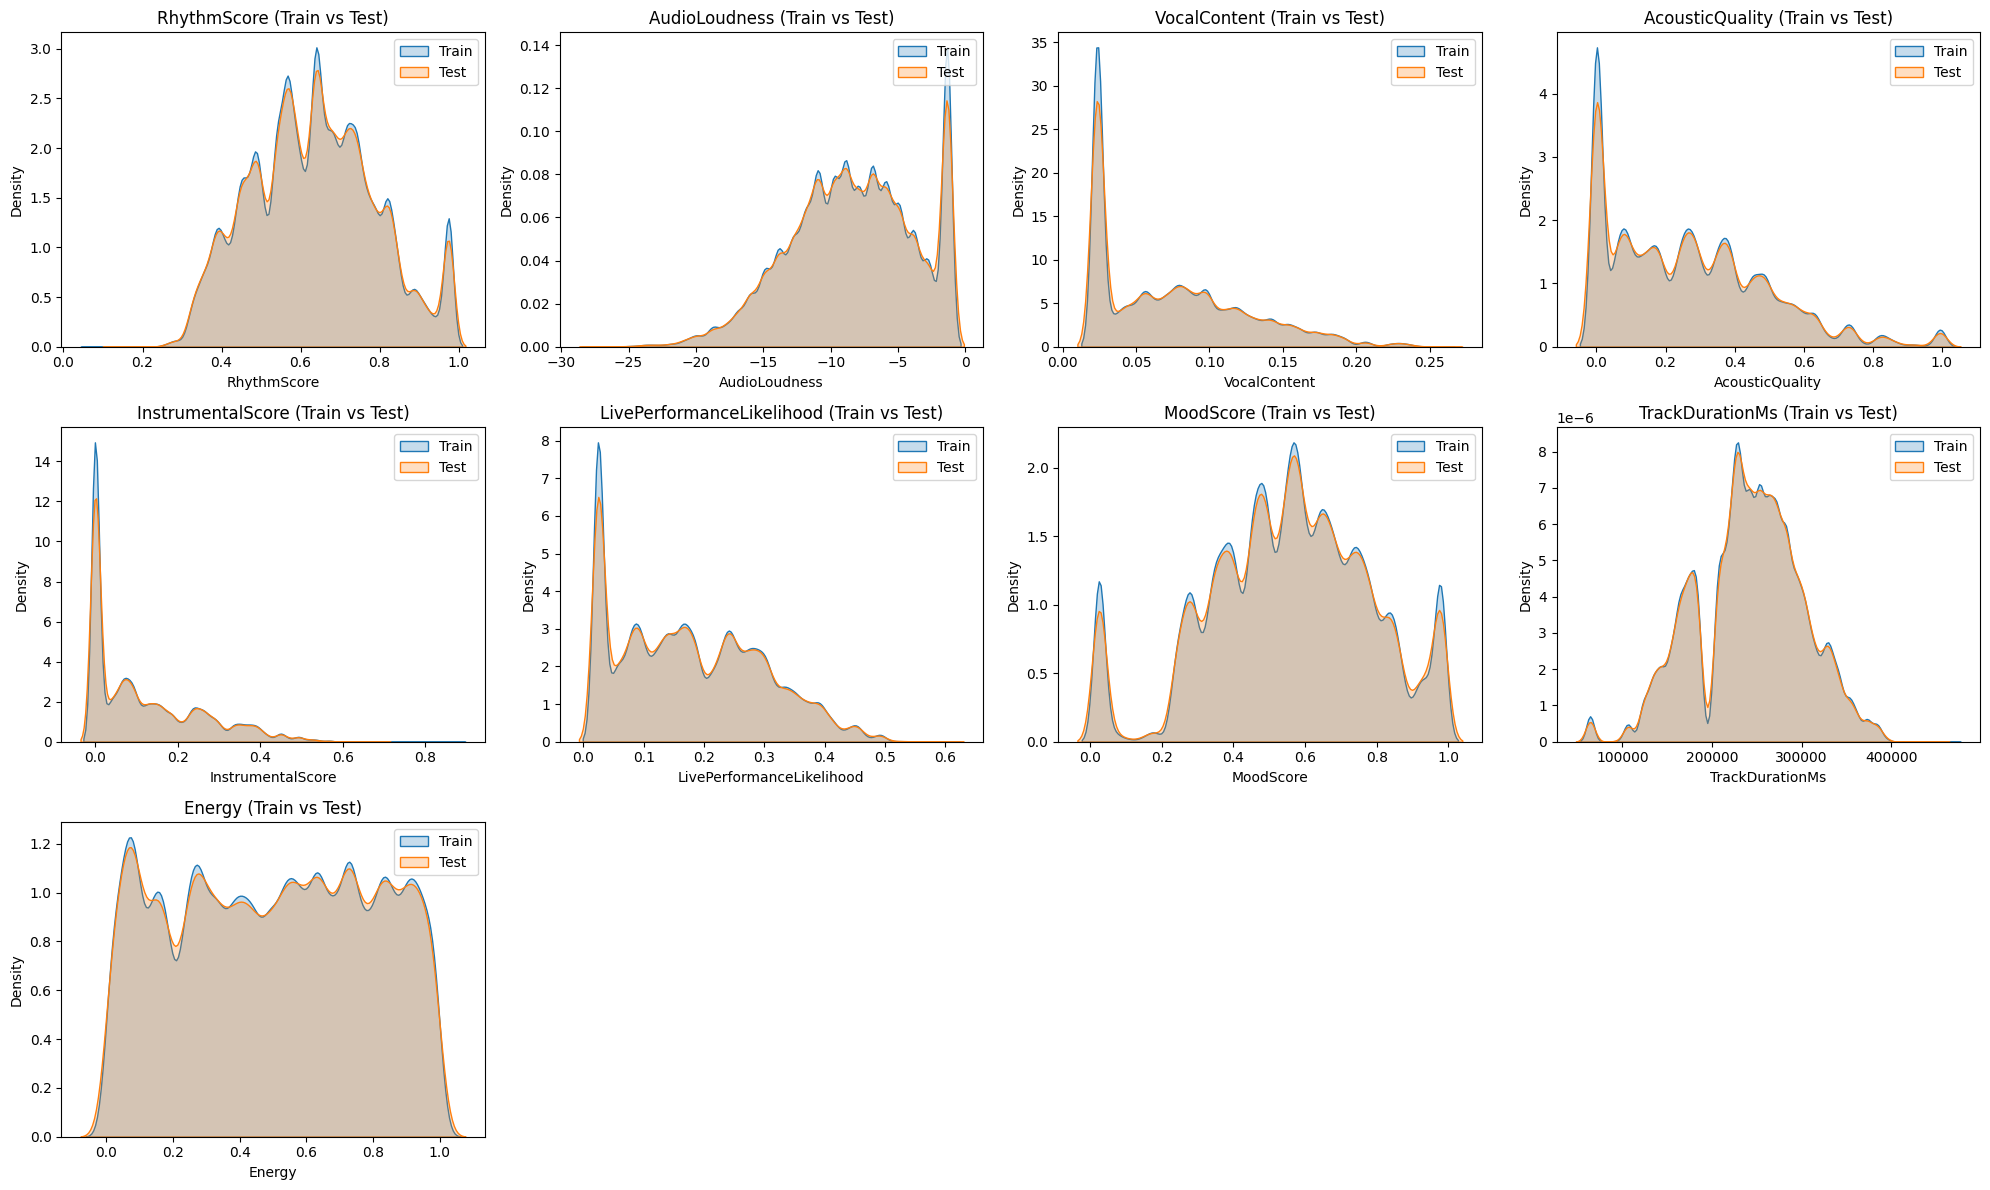

In [11]:


num_features = [col for col in train.columns if col not in ["id", "BeatsPerMinute"]]

rows = len(num_features) // 4 + 1   
fig, axes = plt.subplots(rows, 4, figsize=(20, 4*rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.kdeplot(train[col], label="Train", shade=True, ax=axes[i])
    sns.kdeplot(test[col], label="Test", shade=True, ax=axes[i])
    axes[i].set_title(f"{col} (Train vs Test)")
    axes[i].legend()

# remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Scaling Check

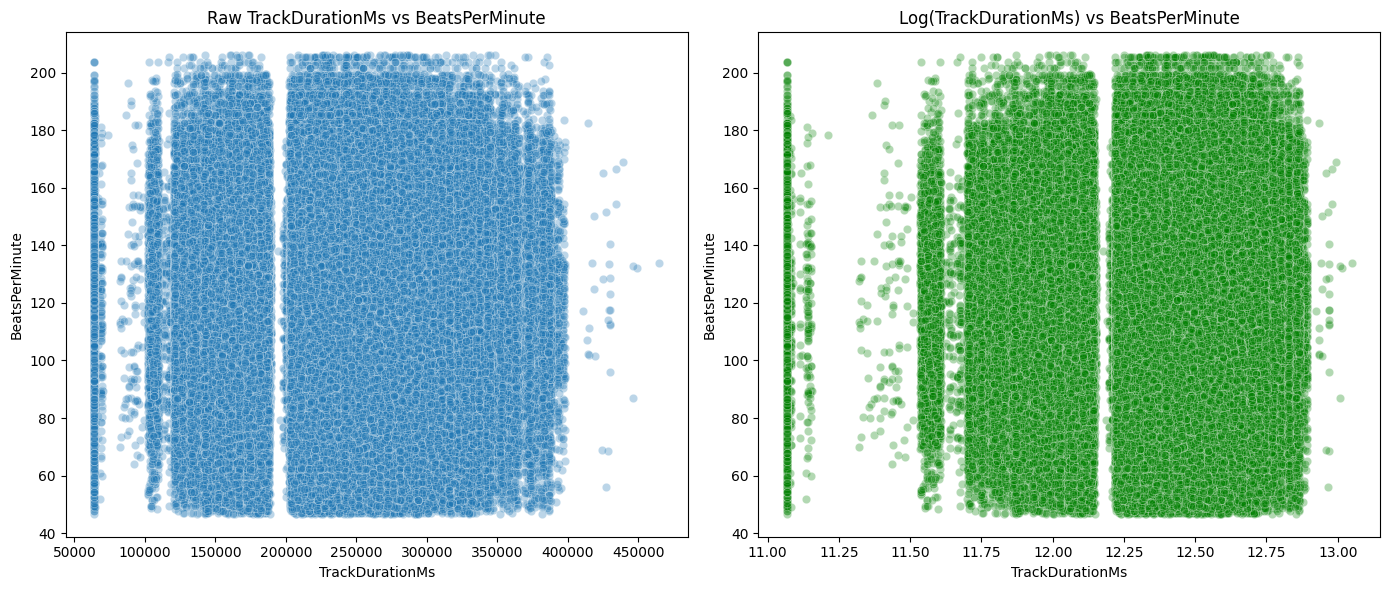

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14,6))

# Raw TrackDurationMs vs BPM
plt.subplot(1,2,1)
sns.scatterplot(x=train["TrackDurationMs"], y=train["BeatsPerMinute"], alpha=0.3)
plt.title("Raw TrackDurationMs vs BeatsPerMinute")

# Log-transformed TrackDurationMs vs BPM
plt.subplot(1,2,2)
sns.scatterplot(x=np.log1p(train["TrackDurationMs"]), y=train["BeatsPerMinute"], alpha=0.3, color="green")
plt.title("Log(TrackDurationMs) vs BeatsPerMinute")

plt.tight_layout()
plt.show()



In [13]:
import numpy as np

corr_raw = train["TrackDurationMs"].corr(train["BeatsPerMinute"])
corr_log = np.log1p(train["TrackDurationMs"]).corr(train["BeatsPerMinute"])

print("Correlation (Raw):", corr_raw)
print("Correlation (Log):", corr_log)



Correlation (Raw): 0.006637172217714405
Correlation (Log): 0.006302045668453874


***Raw (0.0066) → Log (0.0063) → almost the same.***

***👉 That means log transformation did not improve correlation for this variable.***